In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (9,6)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
!pip install lightgbm catboost optuna --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 14.6 MB/s eta 0:00:00


### Data loading

In [3]:
model_df = pd.read_parquet('/content/drive/MyDrive/model_df.parquet')

In [4]:
model_df.shape

(1344115, 136)

More features

In [5]:
model_df['revolutil_fico'] = model_df['revol_util'] * model_df['fico_score']

In [6]:
model_df['dti_loaninc_ratio'] = model_df['dti_log'] * model_df['loan_amount_income_ratio']

In [7]:
model_df['delinq_coll_bin'] = model_df['delinq_flag'] * model_df['collections_bins']

In [8]:
model_df['emplen_verif'] = model_df['emp_length'] * model_df['verification_status_Verified']

In [9]:
model_df['inst_inc_purpose_debtcon'] = model_df['installment_income_ratio'] * model_df['purpose_debt_consolidation']

In [10]:
model_df['accage_openacc'] = model_df['account_age_years'] * model_df['open_acc']

In [11]:
X = model_df.drop(columns=['loan_status'])
y = model_df['loan_status']

### Subsampling

In [12]:
X_sub,_,y_sub,_ = train_test_split(X,y,train_size=0.3,stratify=y,random_state=42)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_sub,y_sub,test_size=0.2,stratify=y_sub,random_state=42)

### Hyperparameters tuning using **optuna**

In [ ]:
import optuna
import xgboost as xgb

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 4),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 3, 6),
        'random_state': 42,

        'early_stopping_rounds' : 20
    }

    model = xgb.XGBClassifier(**params)

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    probas = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, probas)

    return auc

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, timeout=3600)

# Train final model with best params
best_params = study.best_trial.params
best_model = xgb.XGBClassifier(**best_params)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Final test predictions
test_probs = best_model.predict_proba(X_test)[:, 1]
test_preds = best_model.predict(X_test)
test_auc = roc_auc_score(y_test, test_probs)
test_report = classification_report(y_test, test_preds)

print("Best hyperparameters:", best_params)
print("Best validation ROC AUC:", study.best_value)
print("Test ROC AUC:", test_auc)
print("Classification report on test set:\n", test_report)


[I 2025-07-29 15:10:05,501] A new study created in memory with name: no-name-fc2a7b50-869e-4520-852f-9b75dbb29cda
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [15:10:17] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-07-29 15:10:18,391] Trial 0 finished with value: 0.734158395231646 and parameters: {'n_estimators': 540, 'max_depth': 6, 'learning_rate': 0.008764150601773588, 'gamma': 0.11542436617903623, 'min_child_weight': 3, 'subsample': 0.6424137541244062, 'colsample_bytree': 0.9470310735807737, 'reg_alpha': 0.5291724916915027, 'reg_lambda': 

Best hyperparameters: {'n_estimators': 944, 'max_depth': 4, 'learning_rate': 0.06296939501995362, 'gamma': 0.49470084266224107, 'min_child_weight': 7, 'subsample': 0.8800704280225073, 'colsample_bytree': 0.5857661985145072, 'reg_alpha': 0.12002226134106342, 'reg_lambda': 2.839977470486064, 'scale_pos_weight': 4.851299799430592}
Best validation ROC AUC: 0.7408187657241574
Test ROC AUC: 0.7362405257351223
Classification report on test set:
               precision    recall  f1-score   support

           0       0.90      0.59      0.72     64545
           1       0.31      0.75      0.44     16102

    accuracy                           0.62     80647
   macro avg       0.61      0.67      0.58     80647
weighted avg       0.79      0.62      0.66     80647



recall for default increased, model predicts 75% of defaults.


---



In [ ]:
optuna.visualization.plot_optimization_history(study).show()

### Training using Native XGBoost API with best parameters

In [ ]:
import xgboost as xgb

# Create DMatrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params = {
    'tree_method': 'hist',
    'device' : 'cuda',
    'predictor': 'gpu_predictor',
    'objective': 'binary:logistic',
    'max_depth': 4,
    'learning_rate': 0.06296939501995362,
    'gamma': 0.49470084266224107,
    'min_child_weight': 7,
    'subsample': 0.8800704280225073,
    'colsample_bytree': 0.5857661985145072,
    'reg_alpha': 0.12002226134106342,
    'reg_lambda': 2.839977470486064,
    'scale_pos_weight': 4.851299799430592,
    'eval_metric': 'auc'
}


bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=944,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=10
)


/usr/local/lib/python3.11/dist-packages/xgboost/callback.py:386: UserWarning: [17:15:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-auc:0.69268	eval-auc:0.69405
[1]	train-auc:0.69699	eval-auc:0.69831
[2]	train-auc:0.70109	eval-auc:0.70160
[3]	train-auc:0.70317	eval-auc:0.70357
[4]	train-auc:0.70388	eval-auc:0.70425
[5]	train-auc:0.70498	eval-auc:0.70512
[6]	train-auc:0.70794	eval-auc:0.70797
[7]	train-auc:0.71006	eval-auc:0.71006
[8]	train-auc:0.71002	eval-auc:0.71014
[9]	train-auc:0.71118	eval-auc:0.71103
[10]	train-auc:0.71289	eval-auc:0.71292
[11]	train-auc:0.71282	eval-auc:0.71286
[12]	train-auc:0.71303	eval-auc:0.71301
[13]	train-auc:0.71338	eval-auc:0.71318
[14]	train-auc:0.71375	eval-auc:0.71336
[15]	train-auc:0.71372	eval-auc:0.71327
[16]	train-auc:0.71372	eval-auc:0.71335
[17]	train-auc:0.71423	eval-auc:0.71373
[18]	train-auc:0.71466	eval-auc:0.71415
[19]	train-auc:0.71509	eval-auc:0.71457
[20]	train-auc:0.71529	eval-auc:0.71482
[21]	train-auc:0.71546	eval-auc:0.71497
[22]	train-auc:0.71574	eval-auc:0.71524
[23]	train-auc:0.71595	eval-auc:0.71542
[24]	train-auc:0.71614	eval-auc:0.71552
[25]	train

In [ ]:
y_proba_xgb = bst.predict(dtest)
y_pred_xgb = (y_proba_xgb > 0.5).astype(int)

# Evaluation
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))

ROC AUC Score: 0.7352263610481707
Confusion Matrix:
 [[37768 26777]
 [ 4007 12095]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.59      0.71     64545
           1       0.31      0.75      0.44     16102

    accuracy                           0.62     80647
   macro avg       0.61      0.67      0.58     80647
weighted avg       0.79      0.62      0.66     80647



### SHAP Values (visualization)

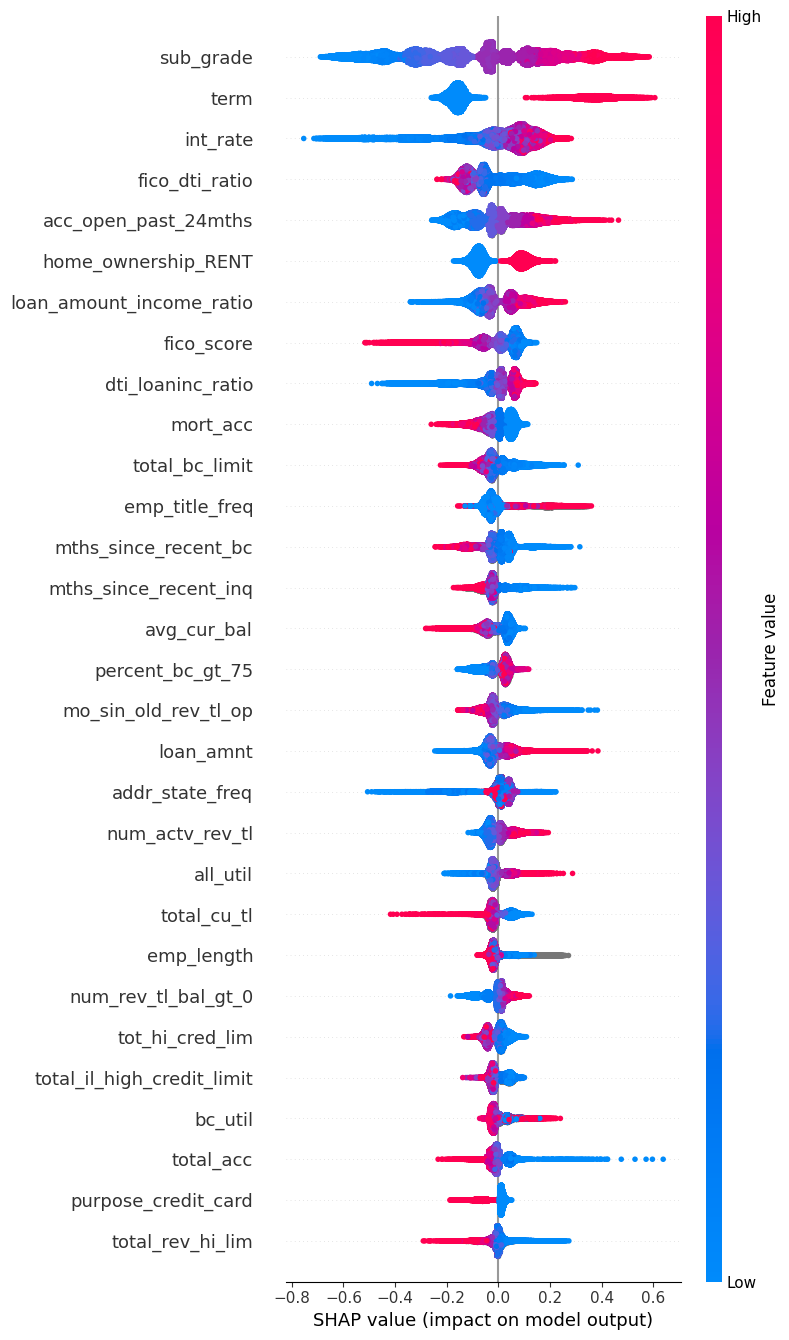

In [ ]:
import shap

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

SHAP dependence plots

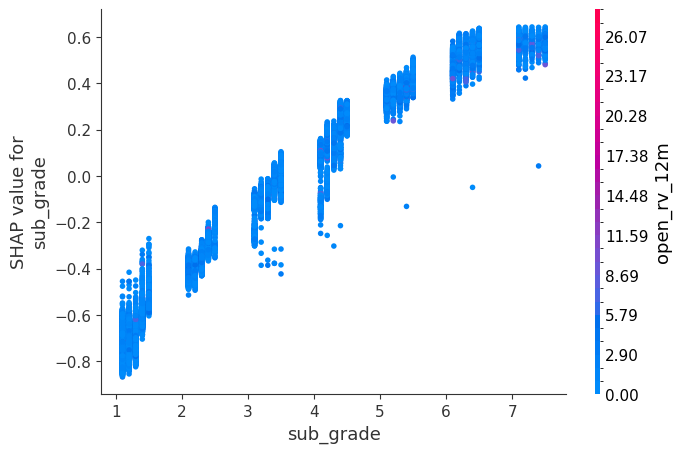

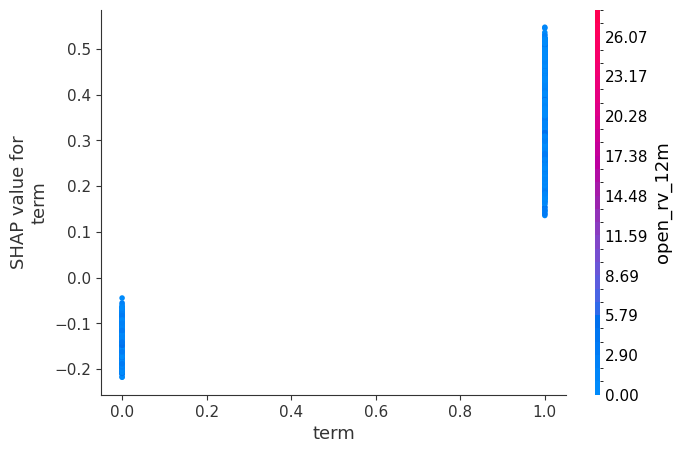

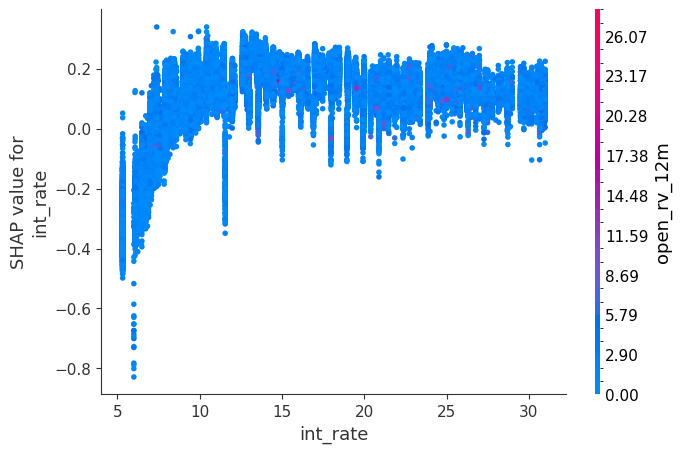

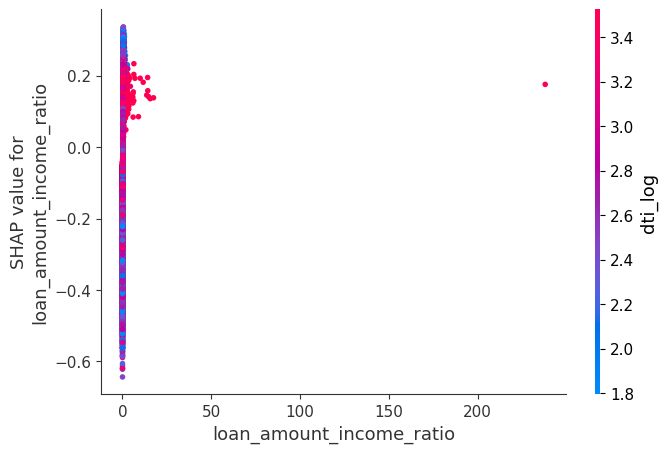

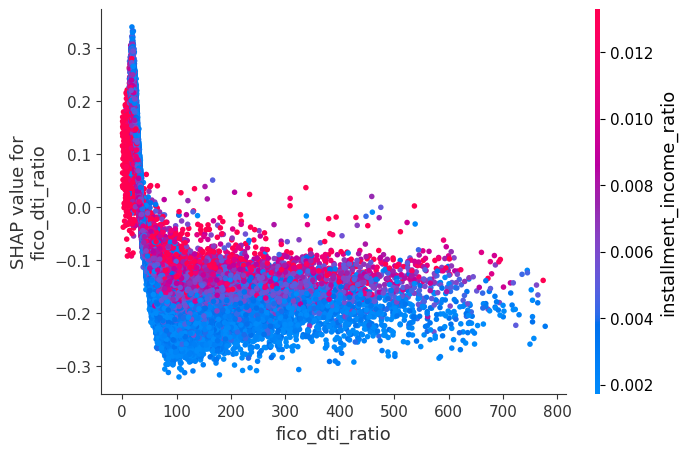

In [ ]:
import numpy as np
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_indices = mean_abs_shap.argsort()[-5:][::-1]
top_features = X_test.columns[top_indices]

for feat in top_features:
    shap.dependence_plot(feat, shap_values, X_test)


### Calibration Curve

In [ ]:
xgb = xgb.XGBClassifier(
    tree_method = 'hist',
    device = 'cuda',
    predictor = 'gpu_predictor',
    objective = 'binary:logistic',
    max_depth = 4,
    learning_rate = 0.06296939501995362,
    gamma = 0.49470084266224107,
    min_child_weight = 7,
    subsample = 0.8800704280225073,
    colsample_bytree = 0.5857661985145072,
    reg_alpha = 0.12002226134106342,
    reg_lambda = 2.839977470486064,
    scale_pos_weight = 4.851299799430592,
    eval_metric = 'auc' ,
    random_state=42
)

In [ ]:
xgb.fit(X_train,y_train)
preds = xgb.predict(X_test)
probs = xgb.predict_proba(X_test)[:,1]

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:17:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [17:17:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [ ]:
print("ROC AUC Score:", roc_auc_score(y_test, probs))
print("Confusion Matrix:\n", confusion_matrix(y_test,preds))
print("Classification Report:\n", classification_report(y_test,preds))

ROC AUC Score: 0.7260848213754365
Confusion Matrix:
 [[36157 28388]
 [ 3910 12192]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.56      0.69     64545
           1       0.30      0.76      0.43     16102

    accuracy                           0.60     80647
   macro avg       0.60      0.66      0.56     80647
weighted avg       0.78      0.60      0.64     80647



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:17:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:17:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:17:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:17:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:18:00] WARNING: /workspace/src/learner.cc:738: 
Pa

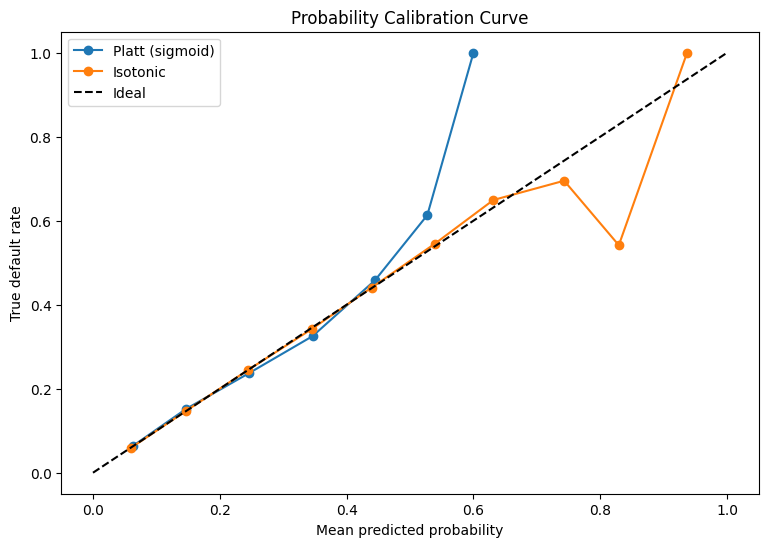

In [ ]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


# 1. Calibrate with Platt scaling (sigmoid)
cal_platt = CalibratedClassifierCV(xgb, method='sigmoid', cv=5)
cal_platt.fit(X_train, y_train)

# 2. Or calibrate with isotonic regression
cal_iso = CalibratedClassifierCV(xgb, method='isotonic', cv=5)
cal_iso.fit(X_train, y_train)

# 3. Get calibrated probabilities
y_proba_platt = cal_platt.predict_proba(X_test)[:, 1]
y_proba_iso = cal_iso.predict_proba(X_test)[:, 1]

# 4. Evaluate calibration visually

for name, y_proba in zip(['Platt (sigmoid)', 'Isotonic'], [y_proba_platt, y_proba_iso]):
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0,1], [0,1], linestyle='--', color='k', label='Ideal')
plt.xlabel("Mean predicted probability")
plt.ylabel("True default rate")
plt.title("Probability Calibration Curve")
plt.legend()
plt.show()


In [ ]:
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_platt))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_iso))

ROC AUC Score: 0.7263090575873024
ROC AUC Score: 0.726222263410059


1. Platt (sigmoid):
Follows the ideal line well up to ~0.45 predicted probability.

*  Then overshoots: for predicted probs 0.5-0.6, actual default rate is much higher (0.6-1.0).

*  Overconfident in this region.

*  Less reliable in the upper range.

2. Isotonic:
Stays close to the ideal line over the whole range.

*  A bit bumpy in higher probabilities (likely due to small sample sizes), but more stable than Platt.

*  Overall, better calibrated here.


---



### Stacking classifier with Xgboost, Lightgbm and Catboost

In [14]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix


xgb_clf = xgb.XGBClassifier(
    n_estimators = 944,
    tree_method = 'hist',
    device = 'cuda',
    predictor = 'gpu_predictor',
    objective = 'binary:logistic',
    max_depth = 4,
    learning_rate = 0.06296939501995362,
    gamma = 0.49470084266224107,
    min_child_weight = 7,
    subsample = 0.8800704280225073,
    colsample_bytree = 0.5857661985145072,
    reg_alpha = 0.12002226134106342,
    reg_lambda = 2.839977470486064,
    scale_pos_weight = 4.851299799430592,
    eval_metric = 'auc',
    random_state = 42
)

lgb_clf = lgb.LGBMClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    class_weight='balanced',
    device = 'gpu',
    random_state=42
)

cat_clf = CatBoostClassifier(
    iterations=400,
    depth=6,
    learning_rate=0.05,
    task_type = 'GPU',
    auto_class_weights='Balanced',
    nan_mode='Min',
    verbose=0,
    random_state=42
)


HistGradient Boosting Classifier as a meta model

In [15]:
estimators = [
    ('xgb', xgb_clf),
    ('lgb', lgb_clf),
    ('cat', cat_clf)
]


from sklearn.ensemble import HistGradientBoostingClassifier

stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=xgb_clf,
    cv=3,
    n_jobs=1,
    passthrough=True
)

stack_clf.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:40:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 64406, number of negative: 258181
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13349
[LightGBM] [Info] Number of data points in the train set: 322587, number of used features: 139
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 77 dense feature groups (24.61 MB) transferred to GPU in 0.044703 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:41:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:729: UserWarning: [14:41:10] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:41:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 42937, number of negative: 172121
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 13356
[LightGBM] [Info] Number of data points in the train set: 215058, number of used features: 139
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 77 dense feature groups (16.41 MB) transferred to GPU in 0.032249 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:43:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


StackingClassifier(cv=3,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5857661985145072,
                                              device='cuda',
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None,
                                              feature_weights=None,
                                              gamma=0.49470084266224107,
                                              grow_policy=None,
                                              i...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.06296939501995362,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=4, max_leaves=None,
                                                 min_child_weight=7,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=944, n_jobs=None,
                                                 num_parallel_tree=None, ...),
                   n_jobs=1, passthrough=True)

In [17]:
y_pred_stack = stack_clf.predict(X_test)
y_proba_stack = stack_clf.predict_proba(X_test)[:, 1]

print(f"Ensemble Stacked ROC AUC: {roc_auc_score(y_test, y_proba_stack):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stack))
print("Classification Report:\n", classification_report(y_test, y_pred_stack))

Ensemble Stacked ROC AUC: 0.7363
Confusion Matrix:
 [[37205 27340]
 [ 3823 12279]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.58      0.70     64545
           1       0.31      0.76      0.44     16102

    accuracy                           0.61     80647
   macro avg       0.61      0.67      0.57     80647
weighted avg       0.79      0.61      0.65     80647



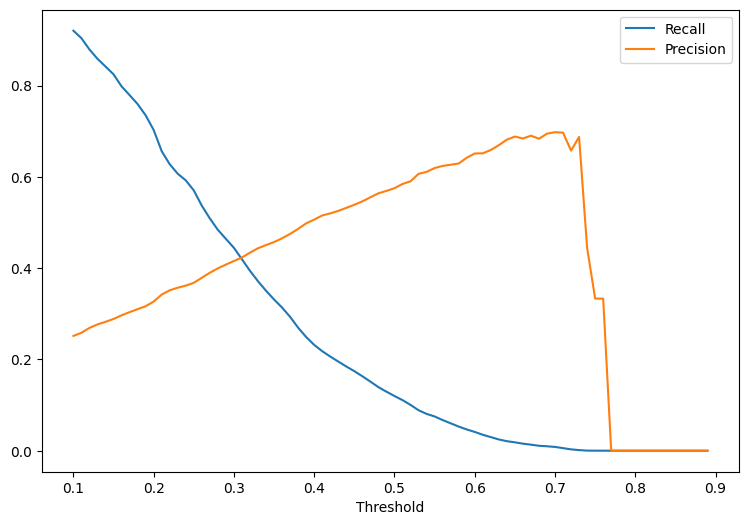

In [23]:
from sklearn.metrics import recall_score, precision_score

thresholds = np.arange(0.1, 0.9, 0.01)
recalls = []
precisions = []
for t in thresholds:
    y_pred_t = (y_proba_stack >= t).astype(int)
    recall = recall_score(y_test, y_pred_t)
    precision = precision_score(y_test, y_pred_t, zero_division=0)
    recalls.append(recall)
    precisions.append(precision)

plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.legend(); plt.xlabel("Threshold"); plt.show()
